In [3]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from model.AE_anbormaly_detection import Autoencoder
from model.Deep_SVDD import DeepSVDD
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [4]:
df=pd.read_csv('E:/glass_git/ML-DL/Signal&Table/data/cromate/preped/df_merged.csv')

features=['pH','Temp','Voltage','run_time','month','day','hour','minutes','seconds']
target=['class']

normal_df=df[df['class']==0]
abnormal_df=df[df['class']==1]


#test에 사용할 normal data sampling
test_lot_index=random.sample(normal_df.Lot.unique().tolist(),9)
test_lot_index+=abnormal_df.Lot.unique().tolist()

#train test split, test set에 normal Lot 9개, abnormal Lot 9개(전체)
train_df=normal_df[~normal_df['Lot'].isin(test_lot_index)]
test_df=df[df['Lot'].isin(test_lot_index)]

#scaled data
scaler=StandardScaler()
scaled_x_train=scaler.fit_transform(train_df[features])
scaled_x_test=scaler.transform(test_df[features])

print(f'train x data: {scaled_x_train.shape},train y data: {train_df[target].shape}')
print(f'test x data: {scaled_x_test.shape},test y data: {test_df[target].shape}')


train x data: (48067, 9),train y data: (48067, 1)
test x data: (1199, 9),test y data: (1199, 1)


In [5]:
scaled_x_train = torch.tensor(scaled_x_train, dtype=torch.float32)  # 변환
train_loader = DataLoader(TensorDataset(scaled_x_train), batch_size=256, shuffle=False)
X_test = torch.tensor(scaled_x_test, dtype=torch.float32)

# ---- Choose objective ----
deepsvdd = DeepSVDD(in_dim=9, rep_dim=16, objective="one-class")             # hard-boundary
# deepsvdd = DeepSVDD(in_dim=9, rep_dim=16, objective="soft-boundary", nu=0.05)  # soft-boundary

deepsvdd.fit(train_loader, lr=1e-3, weight_decay=1e-6, epochs=50, R_update_freq=5)

# 예측
# y_pred, scores = deepsvdd.predict(X_test,)

[001/50] loss=0.011155
[002/50] loss=0.004589
[003/50] loss=0.003074
[004/50] loss=0.002228
[005/50] loss=0.001657
[006/50] loss=0.001173
[007/50] loss=0.000800
[008/50] loss=0.000566
[009/50] loss=0.000430
[010/50] loss=0.000323
[011/50] loss=0.000247
[012/50] loss=0.000202
[013/50] loss=0.000186
[014/50] loss=0.000201
[015/50] loss=0.000243
[016/50] loss=0.000271
[017/50] loss=0.000304
[018/50] loss=0.000422
[019/50] loss=0.000575
[020/50] loss=0.000696
[021/50] loss=0.000497
[022/50] loss=0.000217
[023/50] loss=0.000128
[024/50] loss=0.000112
[025/50] loss=0.000097
[026/50] loss=0.000095
[027/50] loss=0.000110
[028/50] loss=0.000127
[029/50] loss=0.000115
[030/50] loss=0.000057
[031/50] loss=0.000061
[032/50] loss=0.000074
[033/50] loss=0.000091
[034/50] loss=0.000116
[035/50] loss=0.000155
[036/50] loss=0.000124
[037/50] loss=0.000094
[038/50] loss=0.000112
[039/50] loss=0.000121
[040/50] loss=0.000161
[041/50] loss=0.000167
[042/50] loss=0.000186
[043/50] loss=0.000231
[044/50] lo

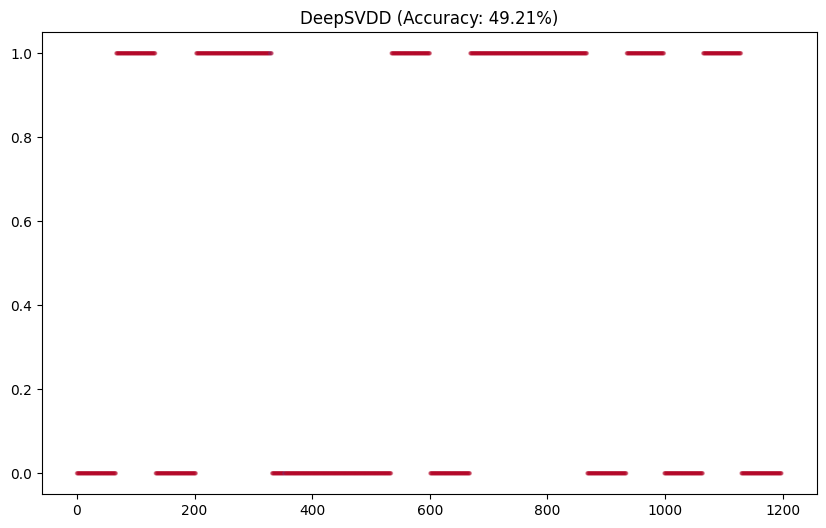

In [6]:
# one-class일 때 임계값을 정하고 싶다면 예시:
if deepsvdd.objective == "one-class":
    # 학습 분포의 95% 분위수를 임계값으로
    with torch.no_grad():
            s_train = deepsvdd.score(scaled_x_train)
    thr = torch.quantile(s_train, 0.97).item()
    y_pred, _ = deepsvdd.predict(X_test, threshold=thr)
    deepsvdd_pred= y_pred

deepsvdd_thr_pred = (deepsvdd_pred > thr).int()
acc=accuracy_score(test_df[target], deepsvdd_thr_pred)
deepsvdd_acc=acc*100
plt.figure(figsize=(10, 6))
plt.scatter(range(len(deepsvdd_thr_pred)), test_df[target], c=deepsvdd_thr_pred, cmap='coolwarm', s=5, alpha=0.3)
plt.title(f'DeepSVDD (Accuracy: {deepsvdd_acc:.2f}%)')
plt.show()
plt.close()

In [8]:
islo = IsolationForest(n_estimators=500,bootstrap=False,random_state=42).fit(scaled_x_train)
islo_pred=islo.predict(scaled_x_test)

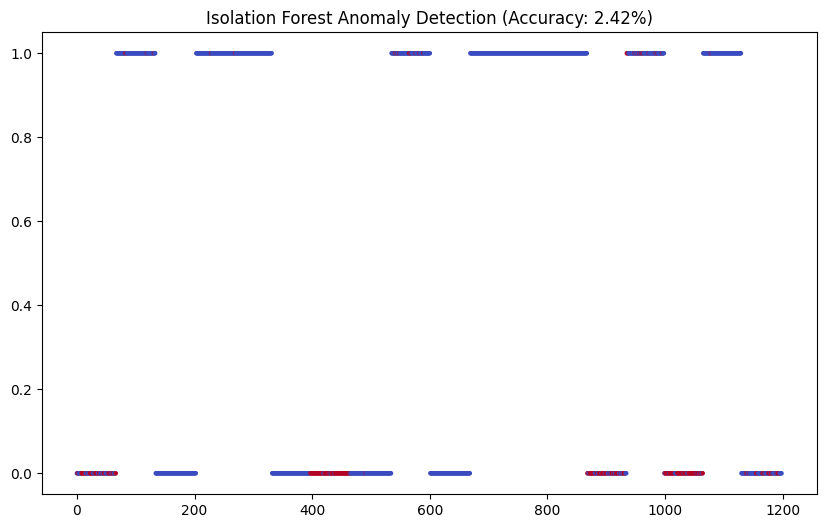

In [9]:
acc=accuracy_score(test_df[target], islo_pred)
islo_acc=acc*100
plt.figure(figsize=(10, 6))
plt.scatter(range(len(islo_pred)), test_df[target], c=islo_pred, cmap='coolwarm', s=5)
plt.title(f'Isolation Forest Anomaly Detection (Accuracy: {islo_acc:.2f}%)')
plt.show()
plt.close()

In [10]:
oneSVM = OneClassSVM(kernel='rbf',gamma='auto').fit(scaled_x_train)
oneSVM_pred=oneSVM.predict(scaled_x_test)

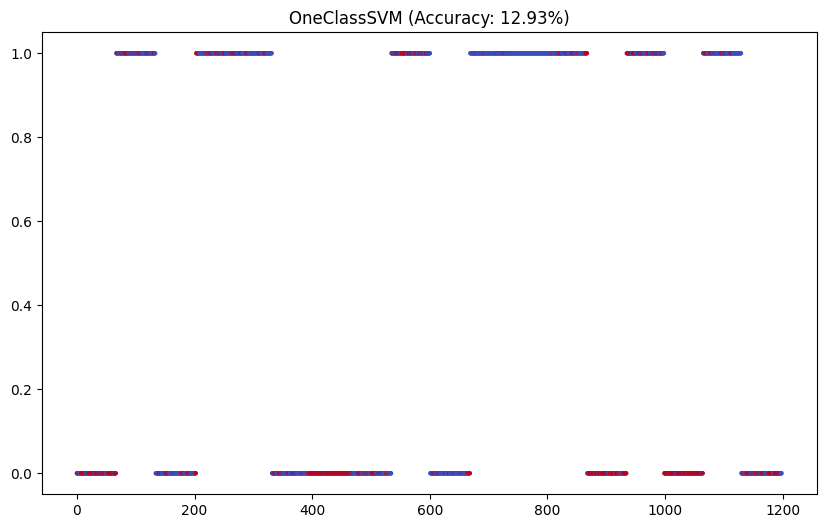

In [11]:
acc=accuracy_score(test_df[target], oneSVM_pred)
oneSVM_acc=acc*100
plt.figure(figsize=(10, 6))
plt.scatter(range(len(oneSVM_pred)), test_df[target], c=oneSVM_pred, cmap='coolwarm', s=5)
plt.title(f'OneClassSVM (Accuracy: {oneSVM_acc:.2f}%)')
plt.show()
plt.close()

In [ ]:
#Autoencoder
scaled_x_train = torch.tensor(scaled_x_train, dtype=torch.float32)  # 변환
train_loader = DataLoader(TensorDataset(scaled_x_train), batch_size=256, shuffle=False)
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# train
for epoch in range(50):
    for i,data in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data[0])
        loss = criterion(outputs, data[0])
        loss.backward()
        optimizer.step()

#reconstruciont error
X_test = torch.tensor(scaled_x_test, dtype=torch.float32)

with torch.no_grad():
    recon = model(X_test)
    errors = torch.mean((X_test - recon) ** 2, dim=1)  # MSE per sample



C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_25984\3826339583.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scaled_x_train = torch.tensor(scaled_x_train, dtype=torch.float32)  # 변환


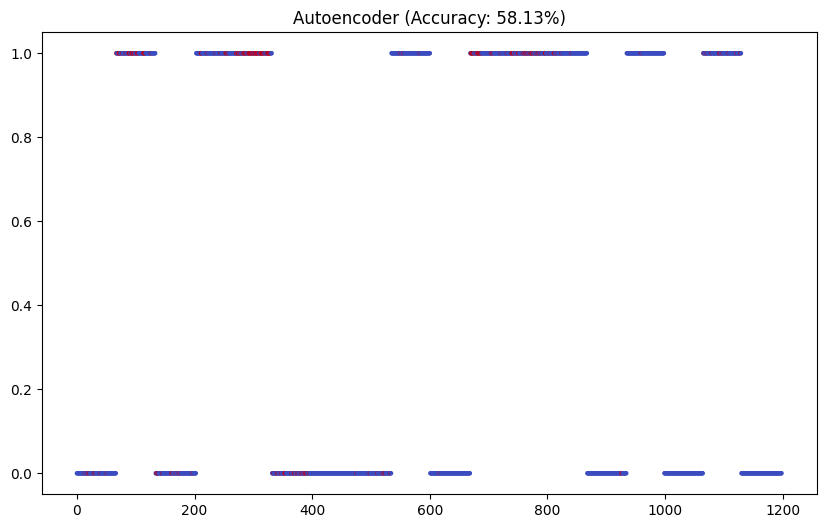

In [13]:
# threhold (정상 데이터 기준 99% 분위수)
threshold = np.percentile(errors[:len(scaled_x_train)], 85)
AE_pred = (errors > threshold).int()

acc=accuracy_score(test_df[target], AE_pred)
AE_acc=acc*100
plt.figure(figsize=(10, 6))
plt.scatter(range(len(AE_pred)), test_df[target], c=AE_pred, cmap='coolwarm', s=5)
plt.title(f'Autoencoder (Accuracy: {AE_acc:.2f}%)')
plt.show()
plt.close()